In [1]:
# Owner: Lia Furtado

In [1]:
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk 
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import unicodedata
from collections import Counter
import spacy
import string
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import math
from gensim.models import word2vec
import time
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding
from plotly.subplots import make_subplots
import plotly.express as px
from gensim.models.ldamodel import LdaModel
from nltk.collocations import *
from gensim.corpora.dictionary import Dictionary
import umap



import seaborn as sns
from itertools import combinations
from sentence_transformers import SentenceTransformer
import nxviz as nv
from nxviz import annotate
import networkx as nx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\lfurtado\Anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## Objectif: 
## Demarche: 
## Introduction/Plan

In [2]:
data = pd.read_csv('dblp_2016_cleaned.csv')  

In [3]:
data['text_clean_tokenized'] = data['text_clean'].apply(lambda x:nltk.word_tokenize(x))


In [4]:
#delete when there is no venue
data = data[~data['venue'].isnull()] 


In [5]:
def cleanup_authors(msg):
    #removing []
    sentence = re.sub(r"[\([{})\]]",r'', msg)
    #removing '' and .
    sentence = sentence.replace("'", "").replace(".", "") 
    sentence = sentence.replace("\\", "").replace("/", "") 
    sentence = sentence.replace('"','') 
    #remove all non latin caracters
    sentence = re.sub(r'[^\x00-\x7f]',r'', sentence)
    #removing digits
    sentence = re.sub("\S*\d+\S*", "", sentence)
    #remove diactric accents and greek letters
    sentence = ''.join(c for c in unicodedata.normalize('NFD', sentence)
                  if unicodedata.category(c) != 'Mn')
    #hyphen the authors
    sentence = list(sentence.split(", "))
    sentence = [word.lower().replace(' ','-') for word in sentence]
    return sentence

In [6]:
def cleanup_venue(msg):
    #removing pontuation
    No_Punctuation = [char if char not in string.punctuation else ' ' for char in msg ]
    sentence = ''.join(No_Punctuation)
    #removing []
    sentence = re.sub(r"[\([{})\]]",r'', msg)
    #removing '' and .
    sentence = sentence.replace(":", "") 
    sentence = sentence.replace(".", "")
    sentence = sentence.replace("\\", "").replace("/", "") 
    sentence = sentence.replace('"','') 
    sentence = sentence.replace("& ", "")
    sentence = sentence.replace("and ", "")
    #hyphen the authors
    sentence = list(sentence.split(", "))
    sentence = [word.lower().replace(' ','-') for word in sentence]
    return sentence

In [7]:
data['authors_clean'] = data['authors'].apply(lambda x:cleanup_authors(x))
data['venue_clean'] = data['venue'].apply(lambda x:cleanup_venue(x))

In [8]:
bag_of_authors = [item for sublist in data['authors_clean'] for item in sublist]

bag_of_venues = [item for sublist in data['venue_clean'] for item in sublist]

Text(0.5, 1.0, 'Top 10 Venues')

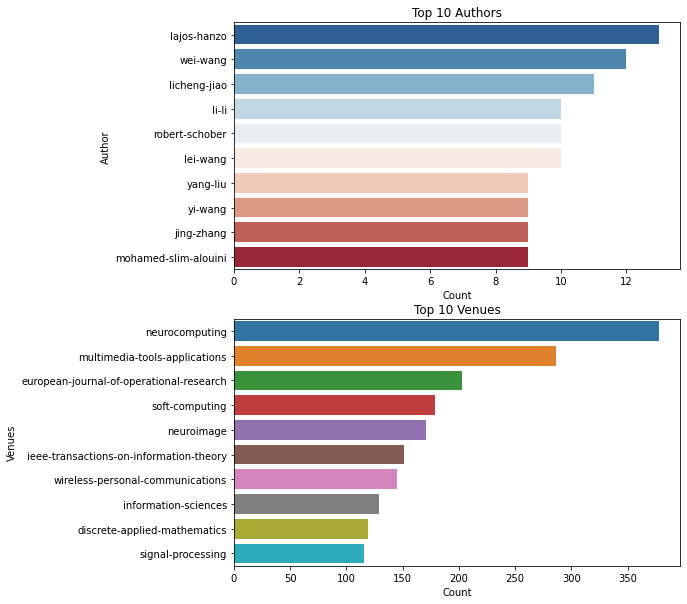

In [9]:
# Top 10 authors
plt.figure(figsize=(8, 10)) 

plt.subplot(2, 1, 1)

top10authors = pd.DataFrame.from_records(
    Counter(bag_of_authors).most_common(10), columns=["Author", "Count"]
)
sns.barplot(x="Count", y="Author", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")

plt.subplot(2, 1, 2)

# TOP 10 Venues
top10venues = pd.DataFrame.from_records(
    Counter(bag_of_venues).most_common(10),
    columns=["Venues", "Count"],
)

sns.barplot(x="Count", y="Venues", data=top10venues)
plt.title("Top 10 Venues")

In [10]:
#Each author now becomes a node and the connection between two is an edge.

In [11]:
data[data['venue_clean'].apply(lambda x: len(set(x))>1)]


,abstract,authors,n_citation,references,title,venue,year,id,text,text_clean,text_clean_tokenized,authors_clean,venue_clean
11,"With the recent development of technology, wir...","['Biljana L. Stojkoska', 'Ilinka Ivanoska', 'D...",50,"['103e12c7-7e82-4a02-a695-155e93f74e14', 'a695...",Wireless Sensor Networks Localization Methods:...,"arXiv: Distributed, Parallel, and Cluster Comp...",2016,91c9a7ae-4cf8-4e7b-a01a-647db5ba4dec,Wireless Sensor Networks Localization Methods:...,wireless sensor localization multidimensional ...,"[wireless, sensor, localization, multidimensio...","[biljana-l-stojkoska, ilinka-ivanoska, danco-d...","[arxiv-distributed, parallel, cluster-computing]"
51,Motif finding is one of the NP-complete proble...,"['Jhoirene B. Clemente', 'Francis George C. Ca...",50,"['36653de4-ccd6-49d2-8f6d-25c1b7f4f856', '4e71...",PROJECTION Algorithm for Motif Finding on GPUs,"arXiv: Distributed, Parallel, and Cluster Comp...",2016,c49bdd5a-4ead-456c-924e-abbb1546c65a,PROJECTION Algorithm for Motif Finding on GPUs...,projection motif finding gpus motif finding np...,"[projection, motif, finding, gpus, motif, find...","[jhoirene-b-clemente, francis-george-c-cabarle...","[arxiv-distributed, parallel, cluster-computing]"
66,Electrodynamic bearings exploit repulsive forc...,"['Nicola Amati', 'Fabrizio Impinna', 'J.G. Det...",0,NaN,Test and theory of electrodynamic bearings cou...,Proceedings of the Institution of Mechanical E...,2016,f52dcb18-54f8-45c2-8d62-b096a2bb0b9c,Test and theory of electrodynamic bearings cou...,test theory electrodynamic bearings coupled ac...,"[test, theory, electrodynamic, bearings, coupl...","[nicola-amati, fabrizio-impinna, jg-detoni, an...",[proceedings-of-the-institution-of-mechanical-...
67,"In this paper, we propose a collective decisio...","['Alexander Scheidler', 'Arne Brutschy', 'Elis...",7,"['0203ea7e-643e-442f-bef1-b2ee7b1da5e3', '074a...",The ${k}$ -Unanimity Rule for Self-Organized D...,"IEEE Transactions on Systems, Man, and Cyberne...",2016,35858dee-d441-4d3a-be7e-a2abe5d2ca87,The ${k}$ -Unanimity Rule for Self-Organized D...,unanimity rule self organized decision making ...,"[unanimity, rule, self, organized, decision, m...","[alexander-scheidler, arne-brutschy, eliseo-fe...","[ieee-transactions-on-systems, man, cybernetics]"
200,The goal of regression testing is to ensure th...,"['Rawad Abou Assi', 'Fadi A. Zaraket', 'Wes Ma...",50,"['022d57a1-668e-4823-bf3e-e1a761a075de', '0302...",UCov: a User-Defined Coverage Criterion for Te...,"Software Testing, Verification & Reliability",2016,9fd02565-1585-4fb6-bb25-704caa4798a7,UCov: a User-Defined Coverage Criterion for Te...,ucov user defined coverage criterion test case...,"[ucov, user, defined, coverage, criterion, tes...","[rawad-abou-assi, fadi-a-zaraket, wes-masri]","[software-testing, verification-reliability]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10839,The homogeneous weight on a finite Frobenius r...,['Heide Gluesing-Luerssen'],50,"['0138c35e-2003-44e8-8286-37897684db04', '27dc...",The homogeneous weight partition and its chara...,"Designs, Codes and Cryptography",2016,32e777af-bd22-46c7-bed4-64fe216a48f7,The homogeneous weight partition and its chara...,homogeneous weight partition character theoret...,"[homogeneous, weight, partition, character, th...",[heide-gluesing-luerssen],"[designs, codes-cryptography]"
10889,An optimal control method is developed for unk...,"['Ruizhuo Song', 'Frank L. Lewis', 'Qinglai We...",50,"['08298542-c6c8-4956-902a-b3c68716950a', '0fa4...",Off-Policy Actor-Critic Structure for Optimal ...,"IEEE Transactions on Systems, Man, and Cyberne...",2016,358ee0b3-9f08-429d-8629-f14bda918252,Off-Policy Actor-Critic Structure for Optimal ...,policy actor critic structure optimal unknown ...,"[policy, actor, critic, structure, optimal, un...","[ruizhuo-song, frank-l-lewis, qinglai-wei, hua...","[ieee-transactions-on-systems, man, cybernetics]"
10959,This paper introduces a new system-level fault..

In [12]:
data[data['authors_clean'].apply(lambda x: '-keskin' in x) ]


,abstract,authors,n_citation,references,title,venue,year,id,text,text_clean,text_clean_tokenized,authors_clean,venue_clean
8905,With high-order methods becoming increasingly ...,"['David Moxey', 'D. Ekelschot', 'Ü. Keskin', '...",12,"['10be84e2-41ff-444e-84f5-cdb26b8919c8', '29f5...",High-order curvilinear meshing using a thermo-...,Computer-aided Design,2016,64e57559-cc34-43b0-99d7-2da15c1d051f,High-order curvilinear meshing using a thermo-...,curvilinear meshing thermo elastic analogy bec...,"[curvilinear, meshing, thermo, elastic, analog...","[david-moxey, d-ekelschot, -keskin, spencer-j-...",[computer-aided-design]


In [13]:
data.iloc[8801]

abstract                With high-order methods becoming increasingly ...
authors                 ['David Moxey', 'D. Ekelschot', 'Ü. Keskin', '...
n_citation                                                             12
references              ['10be84e2-41ff-444e-84f5-cdb26b8919c8', '29f5...
title                   High-order curvilinear meshing using a thermo-...
venue                                               Computer-aided Design
year                                                                 2016
id                                   64e57559-cc34-43b0-99d7-2da15c1d051f
text                    High-order curvilinear meshing using a thermo-...
text_clean              curvilinear meshing thermo elastic analogy bec...
text_clean_tokenized    [curvilinear, meshing, thermo, elastic, analog...
authors_clean           [david-moxey, d-ekelschot, -keskin, spencer-j-...
venue_clean                                       [computer-aided-design]
Name: 8905, dtype: object

In [14]:
data['authors_clean'].iloc[8907]

['am-devlin',
 'marilyn-rose-mcgee-lennon',
 'catherine-odonnell',
 'matt-mouley-bouamrane',
 'ruth-agbakoba',
 'siobhan-oconnor',
 'eleanor-grieve',
 'tracy-finch',
 'sally-wyke',
 'n-watson',
 'susan-browne',
 'frances-mair']

In [15]:
df_connections = data[['title', 'text_clean', 'authors_clean', 'venue_clean']]

In [16]:
df_connections.shape

(11130, 4)

In [17]:
df_connections['authors_combination'] = df_connections['authors_clean'].apply(lambda x: list(combinations(x[::-1], 2)))

C:\Users\lfurtado\AppData\Local\Temp\ipykernel_22632\948579405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connections['authors_combination'] = df_connections['authors_clean'].apply(lambda x: list(combinations(x[::-1], 2)))


In [18]:
df_connections = df_connections.explode('authors_combination','venue_clean')

In [19]:
df_connections = df_connections[~df_connections['authors_combination'].isnull()] 
df_connections.reset_index(inplace=True, drop=True)

In [20]:
df_connections['From'], df_connections['To'] = zip(*df_connections.authors_combination)

In [21]:
df_connections

,title,text_clean,authors_clean,venue_clean,authors_combination,From,To
0,Width of Points in the Streaming Model,width points streaming article compute width d...,"[alexandr-andoni, huy-l-nguyn]",[symposium-on-discrete-algorithms],"(huy-l-nguyn, alexandr-andoni)",huy-l-nguyn,alexandr-andoni
1,Multi-view Metric Learning for Multi-view Vide...,multi view metric multi view video summarizati...,"[linbo-wang, xianyong-fang, yanwen-guo, yanwei...",[cyberworlds],"(yanwei-fu, yanwen-guo)",yanwei-fu,yanwen-guo
2,Multi-view Metric Learning for Multi-view Vide...,multi view metric multi view video summarizati...,"[linbo-wang, xianyong-fang, yanwen-guo, yanwei...",[cyberworlds],"(yanwei-fu, xianyong-fang)",yanwei-fu,xianyong-fang
3,Multi-view Metric Learning for Multi-view Vide...,multi view metric multi view video summarizati...,"[linbo-wang, xianyong-fang, yanwen-guo, yanwei...",[cyberworlds],"(yanwei-fu, linbo-wang)",yanwei-fu,linbo-wang
4,Multi-view Metric Learning for Multi-view Vide...,multi view metric multi view video summarizati...,"[linbo-wang, xianyong-fang, yanwen-guo, yanwei...",[cyberworlds],"(yanwen-guo, xianyong-fang)",yanwen-guo,xianyong-fang
...,...,...,...,...,...,...,...
58854,A robust optimization model for agile and buil...,robust optimization agile build supply chain p...,"[morteza-lalmazloumian, kuan-yew-wong, kannan-...",[annals-of-operations-research],"(devika-kannan, kuan-yew-wong)",devika-kannan,kuan-yew-wong
58855,A robust optimization model for agile and buil...,robust optimization agile build supply chain p...,"[morteza-lalmazloumian, kuan-yew-wong, kannan-...",[annals-of-operations-research],"(devika-kannan, morteza-lalmazloumian)",devika-kannan,morteza-lalmazloumian
58856,A robust optimization model for agile and buil...,robust optimization agile build supply chain p...,"[morteza-lalmazloumian, kuan-yew-wong, kannan-...",[annals-of-operations-research],"(kannan-govindan, kuan-yew-wong)",kannan-govindan,kuan-yew-wong
58857,A robust optimization model for agile and buil...,robust optimization agile build supply chain p...,"[morteza-lalmazloumian, kuan-yew-wong, kannan-...",[annals-of-operations-research],"(kannan-govindan, morteza-lalmazloumian)",kannan-govindan,morteza-lalmazloumian


In [22]:
df_graph = df_connections.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]

In [23]:
G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

In [277]:
node = 'andrei-m-sukhov'
df_connections['venue_clean'][(df_connections['From'] == node) | (df_connections['To'] == node)]

23900    [journal-of-high-speed-networks]
23903    [journal-of-high-speed-networks]
23905    [journal-of-high-speed-networks]
23906    [journal-of-high-speed-networks]
Name: venue_clean, dtype: object

In [278]:
for node in G.nodes():
    G.nodes[node]["venue"] = list(df_connections['venue_clean'][(df_connections['From'] == node) | (df_connections['To'] == node)])[0][0]

-keskin
d-ekelschot
david-moxey
a-a-bukatov
a-k-pervitsky
andrei-m-sukhov
m-a-astrakhantseva
s-boldyrev
a-al-yaari
j-p-wigneron
nj-rodrguez-fernndez
r-van-der-schalie
yann-h-kerr
a-astrid-pieterse
bmp-bart-jansen
a-bellagi
housam-binous
slim-kaddeche
a-ben-hamza
mohammed-khader
a-c-cem-say
abuzer-yakaryilmaz
a-chincarini
marina-boccardi
nicola-amoroso
rosalia-maglietta
stefania-bruno
a-corbo-esposito
f-calabr
a-csik
g-l-katona
h-zaka
m-medhat
s-s-fouad
ss-shenouda
a-d-sarma
v-satya-srinivas
a-david-edwards
antonios-makropoulos
britta-hning
joseph-v-hajnal
nazakat-merchant
nora-tusor
paul-aljabar
robert-wright
tomoki-arichi
a-de-los-reyes-guzmn
fernando-trincado-alonso
iris-dimbwadyo-terrer
a-enis-cetin
deniz-cansen-yildirim
kivanc-kose
mohammad-tofighi
onur-yorulmaz
rengul-cetin-atalay
a-focke
b-threr
c-stockinger
a-g-de-kok
aye-gnl-karaarslan
johan-marklund
olof-stenius
a-g-kusraev
elena-k-basaeva
a-goswami
dipana-jyoti-mohanty
ravi-shankar-kumar
a-h-bentbib
h-barkouki
a-habibi-rad
s-

mrigank-sharad
abida-ellahi
freeha-ihsan
momna-yousaf
abigail-durrant
chris-elsden
dave-kirk
abilio-lucena
alexandre-salles-da-cunha
jesus-ossian-cunha
luidi-simonetti
luis-henrique-bicalho
abir-das
anirban-chakraborty
abla-kammoun
axel-mueller
khalil-elkhalil
romain-couillet
abner-j-salgado
enrique-otarola
ricardo-h-nochetto
abolfazl-aleahmad
hossein-shad-manaman
shahram-jamali
abolfazl-asudeh
ning-yan
sona-hasani
abolfazl-toroghi-haghighat
hamed-orojloo
aboul-ella-hassanien
eid-emary
hossam-m-zawbaa
mona-m-soliman
abraham-goldstein
jonathan-levy
abraham-o-fapojuwo
xiaobin-yang
abu-khari-bin-aain
sahar-sarafi
abubakar-bala
sadiq-m-sait
arseny-m-shur
achille-felicetti
franco-niccolucci
paola-ronzino
achille-p-caputi
alessandro-filippi
carlo-piccinni
claudio-cricelli
emiliano-sessa
francesco-lapi
giampiero-mazzaglia
gianluca-trifir
giovanna-sini
iacopo-cricelli
paola-cutroneo
achim-wambach
elena-katok
nicolas-fugger
achraf-ben-hamadou
ahmed-rekik
adam-belloum
spiros-koulouzis
adam-betts

andrew-d-king
tomas-boothby
aidan-sims
alex-kumjian
david-pask
aidan-slingsby
jason-dykes
sarah-goodwin
aiguo-song
xiaoyong-yan
zhong-yang
aihua-wang
xiaoyue-liu
yanbing-ju
aihua-yin
lei-wang
aijun-an
ricky-fok
aijun-liu
beifang-bao
qi-an-chen
yu-yang
aiko-pras
nils-miro-rodday
ricardo-de-oliveira-schmidt
aili-wang
chao-wang
xi-li
xuehai-zhou
aiman-h-el-maleh
aimin-tang
wenguang-mao
xudong-wang
aimin-wang
geng-sun
jing-zhang
yanheng-liu
aimin-xu
zhongdi-cen
aina-rodrguez-pujadas
csar-vila
paola-fuentes-claramonte
ainhoa-garca-familiar
ivn-maca
jon-haitz-legarreta
jos-ignacio-emparanza
jos-mara-egaa
luis-kabongo
mariano-de-blas
oscar-prez-hernndez
aini-hussain
haitham-abdulmohsin-afan
mohammed-hameed
wan-hanna-melini-wan-mohtar
aiqing-zhang
tong-xiang-gu
xian-yu-zuo
xiaowen-xu
zeyao-mo
airlie-chapman
saghar-hosseini
aisha-al-mutairi
hamdi-yahyaoui
aishy-amer
eva-rifkah
aitzol-ezeiza
arkaitz-zubiaga
iaki-alegria
iaki-san-vicente
jos-ramom-pichel
nora-aranberri
pablo-gamallo
aixia-liu
jun

joshua-mullins
lin-sun
sankaran-mahadevan
you-ling
aleko-gvaramia
elena-aladova
aleksandar-antonic
kreimir-pripui
lea-skorin-kapov
martina-marjanovi
aleksandar-ichkov
katerina-smiljkovikj
aleksandar-ili
kexiang-xu
kinkar-chandra-das
lihua-feng
zhibin-du
aleksandar-ilic
diego-f-de-souza
aleksandar-s-stanimirovic
leonid-stoimenov
nikola-davidovic
aleksandar-zunjic
evica-stojiljkovic
goran-lj-janackovic
miroljub-grozdanovic
suzana-savic
aleksandr-diment
joonas-nikunen
aleksandr-myllri
nikita-gogin
aleksandr-y-aravkin
giulio-bottegal
karthikeyan-natesan-ramamurthy
aleksandra-jovanovic
batrice-brard
serge-haddad
aleksandra-m-walczak
andrew-mugler
chris-h-wiggins
grol-m-sel
jintao-liu
luke-hayden
mark-kittisopikul
aleksandra-maksimova
andrzej-matiolaski
aleksandra-z-jovanovic
jelena-nikolic
zoran-h-peric
aleksandrs-belovs
andris-ambainis
aleksandrs-slivkins
ittai-abraham
omar-alonso
rajesh-patel
steven-shelford
vasilis-kandylas
alemu-gonsamo
holly-croft
jan-pisek
jane-liu
jing-chen
liming-he

luz-lozano
sergio-nesmachnow
uwe-schwiegelshohn
alexander-zimmermann
manuel-saorn
alexandr-v-kostochka
ervin-gyri
jaehoon-kim
alexandra-birch
barry-haddow
rico-sennrich
alexandra-duma
alexandru-topirceanu
alexandra-kolla
ankit-singla
guy-kindler
p-brighten-godfrey
sangeetha-abdu-jyothi
alexandra-saracino
ian-fox
matthew-dobson
alexandra-schwartz
christian-kanzow
oleg-burdakov
alexandra-vivien-van-geen
iris-bohnet
alexandra-von-meier
reza-arghandeh
alexandre-arenas
albert-sol-ribalta
manlio-de-domenico
sergio-gmez
alexandre-b-simas
wagner-barreto-souza
alexandre-blondin-mass
philippe-vincent-lamarre
alexandre-cristovo-maiorano
francisco-louzada
alexandre-daspremont
fajwel-fogel
irne-waldspurger
alexandre-donz
sergiy-bogomolov
alexandre-dupuis
anton-golub
gregor-chliamovitch
alexandre-ern
fabien-casenave
vt-dolej
alexandre-frchette
bernd-bischl
lars-kotthoff
marius-thomas-lindauer
pascal-kerschke
yuri-malitsky
mohammad-reza-khanzadi
narayanan-krishnan
rajet-krishnan
yongpeng-wu
alexandre

c-jones
eric-m-clark
jake-ryland-williams
allison-neyer
don-brian-murphy
michele-l-hammers
stephanie-e-august
allison-theobold
alice-zhuo-yu-chan
logan-stokols
martin-s-copenhaver
sivaram-k-narayan
allister-loder
felix-lossin
allon-g-percus
kristina-lerman
laura-m-smith
linhong-zhu
alma-savoy
annie-coriolan
cheryl-l-holt
daisy-le
darlene-r-saunders
min-qi-wang
almoalmi-ammar
min-liu
zhuo-tang
almut-e-d-veraart
andrea-granelli
alois-panholzer
markus-kuba
alok-atreya
alon-eilam
amir-burshtein
michael-birk
tanya-chernyakova
alon-naor
dan-hefetz
michael-krivelevich
alon-schclar
amir-averbuch
arik-nemtsov
alonso-martinez-canabal
clement-hamani
m-mallar-chakravarty
alonso-perez-soltero
mario-barcelo-valenzuela
patricia-shihemy-carrillo-villafaa
alper-atamtrk
deepak-rajan
pelin-damc-kurt
simge-kkyavuz
alper-bayrak
baris-bidikli
enver-tatlicioglu
erkan-zergeroglu
alpha-tom-kodamullil
mufassra-naz
alphan-sahin
anas-tom
alta-van-der-merwe
aurona-gerber
james-lapalme
alvaro-escribano
genaro-sucar

yonathan-aflalo
anastasia-s-kalinina
anastasios-d-doulamis
eftychios-protopapadakis
konstantinos-makantasis
anastasios-drosou
konstantinos-moustakas
stavros-papadopoulos
anastasios-g-bakirtzis
dimitrios-k-kyriazidis
stylianos-i-vagropoulos
anastasios-gounaris
maria-kontaki
anastasios-kyrillidis
luca-baldassarre
nirav-bhan
volkan-cevher
anastasios-l-kesidis
thomas-konidaris
anastasios-tefas
alexandros-iosifidis
anat-nusan
ina-blau
yehuda-peled
anatolij-dvureenskij
michal-botur
anatoly-yambartsev
eugene-pechersky
m-gannon
yu-m-suhov
anbal-ollero
jose-a-cobano
leopoldo-rodriguez-salazar
anbo-le
anca-livia-radu
anders-c-hansen
alexander-daniel-jones
ben-adcock
anders-jensen-waud
h-ted-goranson
john-gtze
peter-bernus
anders-jrgensen
hans-jrgen-andersen
hans-skov-petersen
hans-thorhauge-dam
kent-basselbjerg
ole-b-jensen
rikke-gade
sren-zebitz-nielsen
thomas-b-moeslund
anders-karlsson
johan-helsing
anders-larsson
jakob-svensson
anders-lindquist
axel-ringh
johan-karlsson
anders-lundman
martina

andrew-d-m-smith
richard-blythe
andrew-dean-ho
curtis-g-northcutt
andrew-eberhard
jean-pierre-crouzeix
andrew-gillette
michael-s-floater
andrew-goodall
delia-garijo
andrew-h-beck
daniel-schmolze
mayinuer-maitituoheti
sadhika-malladi
sheida-nabavi
andrew-h-stevens
thomas-butkiewicz
andrew-holtzhauer
daniel-graham
gang-zhou
yantao-li
andrew-hughes
branislav-stojkovic
hu-ding
zihe-chen
andrew-j-christlieb
hana-cho
matthew-f-causley
andrew-j-duncan
nathan-barker
andrew-j-fritz
andrew-j-karter
courtney-r-lyles
dean-schillinger
james-d-ralston
jill-allen
robert-nguyen
urmimala-sarkar
andrew-j-newell
daniel-j-bates
andrew-j-weaver
nicky-lewis
andrew-k-massimino
mark-a-davenport
andrew-k-skidmore
atkilt-girma
cajm-de-bie
andrew-le
kimberly-c-claffy
mike-p-wittie
utkarsh-goel
andrew-lim
hu-qin
tian-tian
wenbin-zhu
zhixing-luo
zizhen-zhang
andrew-m-cox
nordiana-ahmad-kharman-shah
soureh-latif-shabgahi
andrew-m-lance
mahyar-shirvanimoghaddam
sarah-j-johnson
andrew-m-smith
andrew-mcconvey
andrew-m

mohammad-peikari
anne-laure-boulesteix
roman-hornung
anne-persson
rose-mharie-hlfeldt
anne-synnes
brian-g-booth
colin-j-brown
kenneth-j-poskitt
ruth-e-grunau
steven-p-miller
vann-chau
anne-ventura
tristan-senga-kiess
anne-weigand
heinz-boeker
martin-walter
annemarie-van-der-linden
disha-shah
geert-de-groof
julie-hamaide
marleen-verhoye
steven-deleye
steven-staelens
annemarie-wolff
jianfeng-zhang
jinsong-wu
jun-zhang
pengmin-qin
rui-dai
weimin-liang
xuehai-wu
ying-mao
yuan-li
zhiyao-wang
zirui-huang
lutz-j
annick-choisier
annelies-braffort
laurence-bolot
maxime-delorme
michael-filhol
annick-valibouze
sajjad-rahmany
annika-raatz
gundula-runge
gunnar-borchert
patrick-henke
annraoi-de-paor
clare-m-davidson
anoop-chaturvedi
amresh-bahadur-pal
ashutosh-kumar-dubey
anouar-el-ghouch
ingrid-van-keilegom
majda-talamakrouni
anqian-wang
buda-su
anrin-chakraborti
sumeet-bajaj
anru-zhang
t-tony-cai
anshul-tyagi
ravinder-kumar
antal-ratku
stefan-feuerriegel
anthony-busson
imen-achour
tarek-bejaoui
an

yair-poleg
ariel-kapusta
marc-d-killpack
ariel-levavi
linus-hamilton
ronald-l-graham
arif-wider
hamid-gholizadeh
arijit-ghosh
arijit-bishnu
kunal-dutta
arijit-sur
nilkanta-sahu
shuvendu-rana
arindam-bandyopadhyay
debjit-roy
arindam-basu
lee-wang-wei
phyo-phyo-san
shaista-hussain
subhrajit-roy
arindam-biswas
oishila-bandyopadhyay
aristides-gionis
eric-malmi
gianmarco-de-francisci-morales
hannu-toivonen
kiran-garimella
pyry-takala
tapani-raiko
aristodemos-pnevmatikakis
nikolaos-katsarakis
arjan-j-geers
ignacio-larrabide
arjen-doelman
bjrn-de-rijk
arjen-e-de-vries
imke-kraai
arko-provo-mukherjee
bibudh-lahiri
arman-ahmadzadeh
vahid-jamali
arman-rahmim
hossein-bazmara
m-soltani
majid-bazargan
mojtaba-mousavi-naeenian
mostafa-sefidgar
armand-joulin
bart-van-merrinboer
armand-lachand
razvan-barbulescu
armando-barbosa
carla-pereira
pedro-fernandes
armando-coco
matteo-semplice
armando-eduardo-de-giusti
augusto-villa-monte
germn-aquino
laura-cristina-lanzarini
armando-j-ros
j-guadalupe-galindo


constance-bainbridge
daniel-borkin
michelle-a-borkin
nam-wook-kim
zoya-bylinskii
audrey-killarney
eckford-culver
kevin-j-oleary
mary-e-lohman
audris-mockus
feng-zhang
augusto-smerzi
t-wasak
aura-conci
felipe-fernandes-cordeiro-de-morais
l-s-conci
leonardo-vieira-neto
n-a-o-s-morais
rick-oliveira-rodrigues
aurelie-charles
napaporn-reeveerakul
aurelio-uncini
danilo-comminiello
michele-scarpiniti
simone-scardapane
aurkene-alzua-sorzabal
carlos-lamsfus
david-martn
aurlien-bellet
igor-colin
stphan-clmenon
aurlien-garivier
emilie-kaufmann
olivier-capp
austin-buchanan
sera-kahruman-anderoglu
austin-r-mast
andra-m-matsunaga
avi-j-h-chanales
franziska-r-richter
aviad-pineles
amir-m-ben-amram
aviad-rubinstein
ashwinkumar-badanidiyuru
christos-alexandros-psomas
christos-h-papadimitriou
george-pierrakos
avinash-g-keskar
stephan-e-vogel
tali-leibovich
avraham-goldstein
yonah-cherniavsky
avraham-morgenstern
nati-linial
avril-drummond
denise-kendrick
pip-logan
russell-marshall
ruth-welsh
steve-summer

brian-d-boyd
kyla-david-gibney
nicholas-s-phillips
robert-l-harrigan
stephen-m-damon
davide-sommacampagna
bc-giri
pranab-biswas
surapati-pramanik
bea-botynszki
tams-vink
beat-p-mller-stich
hannes-kenngott
beate-paulus
andreas-j-achazi
christoph-a-schalley
larissa-k-s-von-krbek
shulai-lei
beatrice-rossi
beatrice-s-knudsen
beatrice-van-der-heijden
hans-heerkens
leo-van-der-wegen
beatrix-vereijken
daniel-schoene
jorunn-l-helbostad
tobias-morat
beatriz-balbs
alejandro-balbs
beatriz-otero
f-solano-feo
jm-guevara-jordan
otilio-rojas
beatriz-s-l-p-de-lima
max-de-castro-rodrigues
bechir-hamdaoui
nadia-adem
bedir-tekinerdogan
geylani-kardas
moharram-challenger
bedrich-benes
eric-galin
eric-gurin
stphane-mrillou
begoa-polonio-lpez
patricia-lpez-monteagudo
begonya-fernandez-ruanova
begonya-garcia-zapirain
ibone-saralegui
yolanda-garcia-chimeno
behnam-taebi
eefje-cuppen
udo-pesch
behnam-vahdani
hossein-gitinavard
s-meysam-mousavi
behnaz-omoomi
akbar-davoodi
ramin-javadi
zeinab-maleki
behrooz-karim

bin-han
yi-shen
bin-hu
riquan-zhang
yiqiang-lu
bin-jiang
chao-yang
fuyang-chen
ling-cai
shuqu-qian
yongqiang-ye
bin-li
bo-yuan
fugui-zhong
kai-chen
xiang-yin
bin-liang
zhendong-wu
bin-liu
aichuan-li
bin-lu
xin-xie
bin-luo
budan-wu
chuanyi-li
haiyang-hu
hao-hu
hongji-yang
jidong-ge
liguo-huang
zhaoxia-yin
bin-ma
zhi-zhong-chen
bin-ning
h-dong
shigen-gao
bin-sheng
florian-barbero
gregory-gutin
li-xia
mark-jones
bin-song
fang-tian
haixiao-liu
bin-wang
tao-zhou
yaobin-lu
bin-wu
jie-xiao
lin-feng
min-wang
shuyuan-yang
yaofang-li
bin-xia
chenchen-yang
jun-rao
zhiyong-chen
bin-xiao
shigeng-zhang
xuan-liu
jianming-zhan
binbin-chen
haifeng-yu
yuda-zhao
binbin-lin
wei-zhao
zheng-liu
ziyu-guan
binbin-xie
liqing-ren
xiaojiang-chen
chun-wei-lin
bineng-zhong
xiangnan-yang
yan-chen
bing-chu
christopher-freeman
engin-h-copur
bing-kun-bao
jitao-sang
yue-gao
bing-li
haijuan-hu
hongzhe-liu
jiazheng-yuan
xiankai-huang
bing-liu
tieyun-qian
bing-nan-li
qiang-yu
xiaojun-yang
bing-ni
haipeng-zeng
huamin-qu
ji

brittany-a-duncan
robin-r-murphy
brittany-g-bryant
brittny-miller
christopher-dieringer
drew-landis
ross-kelly
william-courtney
brook-galna
shirley-coleman
bruce-a-reed
bruce-g-s-hardie
peter-s-fader
bruce-r-rosen
bruce-randall-donald
ivelin-s-georgiev
jonathan-d-jou
swati-jain
bruce-y-lee
diane-k-wagener
philip-c-cooley
sarah-m-bartsch
shawn-t-brown
william-d-wheaton
brunilde-sans
arash-azarfar
jean-franois-frigon
bruno-b-rodrigues
ana-c-riekstin
guilherme-c-januario
bruno-bastide
fabrice-fryziel
jeanpierre-noel
marc-digumber
mariehlne-canu
vincent-tiffreau
bruno-clerckx
duckdong-hwang
bruno-defude
djamal-benslimane
michael-mrissa
mohamed-sellami
pierre-de-vettor
bruno-escoffier
douard-bonnet
bruno-felix-osmanski
claudia-errico
bruno-lepri
elisa-ricci
jacopo-staiano
ligia-maria-batrinca
ramanathan-subramanian
xavier-alameda-pineda
bruno-patrou
jean-gabriel-luque
ludovic-mignot
pascal-caron
bruno-sinopoli
dragana-bajovic
joo-manuel-freitas-xavier
jos-m-f-moura
bruno-soulier
nicolas-cou

rodrigo-o-spnola
yuepu-guo
carolyn-penstein-ros
carrie-r-h-innes
govinda-r-poudel
jlenia-toppi
laura-astolfi
michael-lind-mortensen
yeounoh-chung
carsten-dachsbacher
derek-nowrouzezahrai
fabio-pellacini
gerard-simons
marco-ament
sebastian-herholz
thorsten-schmidt
wojciech-jarosz
carsten-gottschlich
duy-hoang-thai
stephan-huckemann
carsten-h-wolters
sven-wagner
carsten-lund
edith-cohen
graham-cormode
nick-g-duffield
carsten-rother
jeremy-jancsary
sebastian-nowozin
stefan-roth
uwe-schmidt
carsten-wiuf
daniele-cappelletti
cary-y-yang
anshul-a-vyas
changjian-zhou
patrick-wilhite
phillip-wang
casey-tompkins
casian-pantea
murad-banaji
caspar-m-groeneveld
nynke-bos
cassandra-sampaio-baptista
cassidy-r-sugimoto
cassio-polpo-de-campos
emanuele-zucca
francesco-bertoni
marco-zaffalon
paola-m-v-rancoita
cassius-puodzius
geovandro-c-c-f-pereira
catalin-meirosu
tereza-cristina-m-b-carvalho
viviane-t-nascimento
catalin-s-buhimschi
stephan-jonas
thomas-martin-deserno
catalina-sbert
joan-duran
michael-

hong-tang
hongjian-li
yusheng-dou
chen-ju-lai
yin-fu-huang
chen-liang
kai-fan
yuanyuan-gong
chen-lin
joel-f-houston
chen-liu
tianzhang-xing
zhanyong-tang
chen-peng
jin-zhang
chen-qian
xudong-zhu
zhaocheng-wang
chen-tian
fan-zhang
juanjuan-zhao
chen-wang
di-wu
fanyong-meng
hongyan-zhu
hongzhi-lin
junzhi-yu
tingwei-liu
wei-gao
chen-xu-liu
yun-liu
chen-z
qing-liu
chenchen-kong
hong-qiu
jianwei-zheng
wanliang-wang
chenchen-wu
dachuan-xu
fengmin-wang
chencheng-yang
hongyun-chu
pingping-xu
cheng-fu-huang
yi-kuei-lin
cheng-huang
xiaobei-wu
xinjiang-sun
cheng-jung-tsai
ting-yi-chang
cheng-kuan-lin
jianxi-fan
jingya-zhou
xi-wang
cheng-li
ramachandran-venkatesan
ruoyu-su
cheng-lin-liu
fei-yin
guanhua-tian
jiaming-xu
kaizhu-huang
ming-ke-zhou
xu-yao-zhang
yao-lu
cheng-sian-chang
cheng-ta-huang
wei-jen-wang
cheng-ta-yeh
cheng-wang
chunjia-bi
lanjie-guo
yanjiao-wang
ziyi-chen
cheng-wu
jian-ya-ding
jianhua-lin
jinbiao-lin
jinghua-hao
keyou-you
shiji-song
cheng-xiang-wang
shuguang-cui
cheng-yan
xiao-

christian-ibars
giuseppe-cocco
nader-alagha
christian-ikenmeyer
fulvio-gesmundo
jesko-httenhain
christian-kaethner
wolfgang-erb
christian-keitel
sabrina-walter
christian-knauer
otfried-cheong
sergio-cabello
christian-kudahl
joan-boyar
lene-m-favrholdt
christian-labb
magdalena-claro
christian-luksch
johannes-sorger
thomas-ortner
christian-lwenstein
felix-joos
michael-a-henning
michael-gentner
piotr-borowiecki
christian-merdon
martin-eigel
christian-meyer
christian-p-robert
jean-marie-cornuet
mathieu-gautier
christian-pilato
marco-lattuada
christian-prins
h-murat-afsar
juan-carlos-rivera
christian-ritz
christian-rohde
dennis-diehl
dietmar-krner
jenny-kremser
marco-breiling
christian-rosenke
ragnar-nevries
christian-rubio-montiel
dolores-lara
gabriela-araujo-pardo
oswin-aichholzer
thomas-hackl
christian-schulz
peter-sanders
christian-straer
joke-meheus
christian-stroszczynski
hans-j-schlitt
martina-mller
christian-stummer
christine-strauss
marie-luise-leitner
christian-windischberger
chri

zheng-li
chunhwa-choe
gyongil-hyon
qi-feng
tianjiang-wang
chunjiao-miao
hongqiang-li
huan-liang
chunlei-li
cunsheng-ding
chunlei-liu
haode-yan
huihui-ye
jean-c-augustinack
chunliang-wang
hans-frimmel
kristna-lidayov
chunlin-xiong
fanglin-gu
hang-zhang
wenwu-wang
chunmiao-zheng
yi-zheng
yong-tian
chunming-hu
jia-li
shuai-ma
chunming-liu
zhigang-zheng
chunming-lu
gaolang-gong
guosheng-ding
chunming-rong
tahar-kechadi
xianghan-zheng
xueying-zhang
yuanlong-yu
chunming-tang
can-xiang
chunna-tian
chunpeng-gao
yu-gu
chunping-hou
chunqiang-yuan
xiaohui-liang
chunqiao-tan
xiaohong-chen
chunsheng-wang
xin-ran-zhou
chunsheng-zhu
victor-c-m-leung
wenxiang-li
chunwu-liu
junpeng-hu
zhiping-huang
chunxia-zhao
jun-zhou
pu-huang
xun-yu
zhangjing-yang
zhenqiu-shu
chunxian-teng
zhaobo-chen
chunxiang-xu
jiang-deng
chunxiao-jiang
haijun-zhang
chunxiao-tang
lu-cao
xiuli-feng
chunxiao-wang
fenghe-wang
zhen-hua-liu
chunyan-an
jiantao-zhou
weina-fu
chunyan-wang
jun-huang
chunyuan-liao
pengpeng-liang
yu-pang
ch

m-i-berenguer
d-le-touz
g-oger
d-louis-collins
jos-v-manjn
nicolas-papadakis
rmi-giraud
vinh-thong-ta
d-manjunath
nutan-limaye
pooja-vyavahare
d-meister
joachim-kneis
petr-hlinen
robert-ganian
d-michael-miller
mathias-soeken
oliver-keszocze
robert-wille
d-parthasarathy
nikhil-narayanan
d-s-bormane
d-s-emmanuel
j-christopher-clement
d-s-ramana
gyan-prakash
r-balasubramanian
d-t-lee
d-turkoz
yusuf-erzin
d-vecchiato
r-arboretti-giancristofaro
tiziano-tempesta
vasco-boatto
da-zheng-feng
wen-juan-liu
daan-frenkel
tuomas-p-j-knowles
william-m-jacobs
daan-huybrechs
roel-matthysen
dac-binh-ha
enyu-li
xinjie-wang
changxing-ding
jie-gui
jonghyun-choi
weixin-yang
huaping-liu
jeong-ho-kim
jihyung-kim
dae-ki-kang
xiang-ru-yu
zhong-liang-xiang
daehun-nyang
jeong-seop-sim
mun-kyu-lee
pierre-michaud
daehyoung-hong
jaechan-lim
taejin-kim
daekil-park
eylee-jung
daesung-moon
deok-gyu-lee
jong-ho-kim
jun-jae-park
sang-ho-ahn
dagomir-kaszlikowski
dah-jye-lee
alok-desai
dai-quoc-nguyen
dat-quoc-nguyen
daiho

karina-gibert
emiliano-cristiani
giacomo-albi
mattia-bongini
danupon-nanongkai
monika-henzinger
sebastian-krinninger
danwei-wang
chengju-liu
tao-xu
daofu-gong
daoqiang-zhang
jianchun-zhang
mingxia-liu
shu-liao
yanyan-zhang
yaozong-gao
yinghuan-shi
zhisong-pan
daoshun-wang
linming-gong
qing-mao
shundong-li
daoyi-dong
qing-gao
dapeng-man
liangyi-gong
wu-yang
zimu-zhou
dapeng-tao
haifeng-zhang
hongli-liu
lei-xie
tao-zhuo
weifeng-liu
yanning-zhang
dapeng-wu
pan-zhou
yingxue-zhou
daphne-ruth-raban
michal-gaziel-yablowitz
daqi-gao
yujin-zhu
zhe-wang
daqiang-zhang
daqing-wan
matt-keti
darae-jeong
seunggyu-lee
darci-odloak
marcel-joly
dario-bauso
fabio-bagagiolo
adrien-briod
andrea-maesani
giovanni-iacca
jean-christophe-zufferey
dario-trevisan
giacomo-de-palma
darko-huljenic
per-runeson
tihana-galinac-grbac
darko-stosic
dusan-stosic
darrell-d-e-long
yan-li
darren-j-yeo
eric-d-wilkey
gavin-r-price
darren-treanor
fusheng-wang
yanhui-liang
darryl-d-holm
colin-j-cotter
jaap-eldering
darryl-k-ahner

deguang-le
xiaonan-wang
dehai-zhao
xin-liu
yao-wang
dehai-zhu
hao-guo
dehao-li
zunshui-cheng
dehao-yu
hongxing-rui
dehong-gao
naishi-liu
renxian-zhang
wenjie-li
dehua-zhang
wei-liu
dejan-nickovic
bernhard-k-aichernig
florian-lorber
klaus-hormaier
dejan-slepev
nicols-garca-trillos
dejan-v-toi
milka-m-potrebic
sneana-stefanovski
delaram-motamed-vaziri
mohammad-hossein-rohban
venkatesh-saligrama
delbert-humberson
hamed-zamani-sabzi
delphine-longuet
hernn-ponce-de-len
stefan-haar
delu-zeng
liqin-chen
p-zhuang
xianhui-zheng
xinghao-ding
yue-huang
demba-diallo
demetrios-l-antzoulakos
demosthenes-stamatis
deng-cai
haifeng-liu
zheng-yang
denghua-zhong
guichao-fan
dengke-zeng
denis-borenstein
leonardo-rosa-rohde
pablo-cristini-guedes
william-prigol-lopes
denis-helic
simon-walk
denis-kouame
denis-r-merk
mohamed-esmail-karar
denis-talay
julien-claisse
denis-trystram
jacek-blazewicz
jedrzej-musial
nathanal-cheriere
pierre-franois-dutot
denise-a-reyes
kaely-thostenson
reto-meuli
denise-tonissen
j-a

frdric-havet
nick-brettell
do-wan-kim
ho-jae-lee
dohoo-pyeon
ingook-jang
dohyung-kim
jong-hyuk-park
doina-precup
andr-da-motta-salles-barreto
dolly-vijay
m-althaf-hussain
domenico-cotroneo
marcello-cinque
domenico-dalessandro
francesca-albertini
domenico-marsella
naga-vishnukanth-irukulapati
domenico-talia
emmanuel-jeannot
gudula-rnger
jess-carretero
laurent-lefvre
raimondas-iegis
domingo-morales
roberto-benavent
dominic-breit
luigi-c-berselli
dominic-k-c-ho
ali-al-sharadqah
dominic-wrner
thomas-von-bomhard
manfred-pochacker
dominik-engel
christian-neureiter
gnther-eibl
dominik-jstel
gero-friesecke
richard-d-james
dominik-koch
gerhard-tutz
dominik-seu
michael-siebers
ute-schmid
dominikus-baur
alice-thudt
dominikus-krger
britta-dorn
dominikus-noll
heinz-h-bauschke
minh-n-dao
dominique-bechmann
jieqing-feng
xue-chen
dominique-de-werra
konrad-kazimierz-dabrowski
vadim-v-lozin
dominique-feillet
florent-hernandez
dominique-houzet
farouk-mansouri
sylvain-huet
dominique-lepelley
william-v-geh

eduardo-bayro-corrochano
eduardo-vzquez-santacruz
edurne-barrenechea
daniel-gmez
j-tinguaro-rodrguez
javier-montero
edvin-wedin
edward-a-fox
edward-c-sewell
david-r-morrison
edward-furman
alexandru-vali-asimit
edward-grant
nikhil-deshpande
edward-h-kaplan
andrea-seidl
edward-j-auerbach
nick-todd
steen-moeller
edward-k-kasper
eleni-flanagan
jeff-appelbaum
matthew-f-toerper
sauleh-siddiqui
edward-mccormack
edward-s-boyden
edwin-hsing-mean-sha
hui-xia
jia-yu
xiangguo-cheng
zhenkuan-pan
edwin-jacox
edwin-r-hancock
lu-bai
richard-c-wilson
edy-tonnizam-mohamad
danial-jahed-armaghani
eero-sormunen
anni-jrvelin
eero-vyrynen
ilkka-juuso
jukka-holappa
magda-laszlo
efrain-castillo-muis
efstathios-panayi
efstratios-gallopoulos
george-s-atsalakis
eg-patrick-bos
nithin-shivashankar
pratyush-pranav
rien-van-de-weygaert
vijay-natarajan
egils-ginters
miquel-angel-piera
roman-buil
egor-samosvat
liudmila-ostroumova-prokhorenkova
ehab-s-elmallah
ehsan-asadi
mahdi-boloursaz-mashhadi
ehsan-meamari
samaneh-b

li-zhuang
enyu-yao
longcheng-liu
enza-messina
elisabetta-fersini
enzo-pasquale-scilingo
eoin-long
peter-keevash
ephraim-korach
foto-n-afrati
shlomi-dolev
epifanio-morales-zarate
eliseo-hernandez-martinez
francisco-j-valdes-parada
hector-puebla
jose-alvarez-ramirez
gbor-hetyei
ercan-e-kuruoglu
navodit-misra
erchin-serpedin
khalid-a-qaraqe
muhammad-ismail
erdal-arikan
onur-dizdar
erdal-emel
alkn-yurtkuran
erdin-dndar
fatih-nuray
uur-ulusu
erel-segal-halevi
avi-rosenfeld
inon-zuckerman
eren-aolu
henry-d-pfister
marco-mondelli
santhosh-kumar
shrinivas-kudekar
erfan-zamanian
tim-kraska
erfang-shan
yancai-zhao
erhard-rahm
christian-wartner
patrick-arnold
eric-atwell
abdullah-alfaifi
eric-bodden
andreas-follner
max-kolhagen
nicole-eling
siegfried-rasthofer
eric-busvelle
nicolas-boizot
eric-c-holland
linglong-kong
qianchuan-he
sijian-wang
timothy-a-chan
yanhua-wang
eric-c-kansa
patrick-golden
eric-cazzoli
peter-burgherr
eric-d-manley
david-mascharka
eric-darve
amirhossein-aminfar
eric-fosler-l

fadi-almasalha
shadi-banitaan
faezeh-ensan
ebrahim-bagheri
fahad-azim
d-jabeen
g-monir
fahad-panolan
faheem-ahmed
luiz-fernando-capretz
saiqa-aleem
fahimeh-ramezani
khaled-m-elbassioni
kurt-mehlhorn
fahri-vatansever
nedim-aktan-yaln
faisal-bashir-hussain
zara-hamid
faisal-s-al-kamali
abdulmajid-f-al-junaid
falko-kuester
jason-kimball
tom-wypych
fambirai-takawira
babatunde-awoyemi
tom-walingo
fan-ji
xiaoliang-chen
fan-jin
xuan-li
hongying-liu
jiangchuan-liu
ke-xu
meng-shen
fan-min
heng-ru-zhang
fan-sun
guo-feng-fan
li-ling-peng
wei-chiang-hong
fan-wei
changsheng-li
qingshan-liu
weishan-dong
fan-wu
chunchun-wu
saru-kumari
xiong-li
zuying-wei
fan-yang
sizhong-zhou
haijiang-zhu
junhui-sheng
fan-zhong
xinbo-jiang
jie-feng
liyu-gong
meng-chen
pan-lai
rui-fan
fang-ming-shao
nan-qu
fang-qian
fang-qiang-yu
jianping-zhang
jiarui-lin
zhenzhong-hu
jongwon-lee
yong-shi
fang-wei-fu
chengju-li
jian-gao
linzhi-shen
minjia-shi
qin-yue
tingting-wu
xuan-guang
fang-xu
jiangwu-zhao
jiangxin-yang
jiaoliao-c

sonia-mihaela-bogos
florin-avram
voichia-iancu
floris-klumpers
daphne-everaerd
flvio-montenegro
vincius-leal-do-forte
fodil-fadli
l-mahdjoubi
pawel-boguslawski
v-zverovich
fokie-cnossen
wiard-jorritsma
folke-isaksson
bertil-grelsson
michael-felsberg
folke-mitzlaff
martin-atzmueller
stephan-doerfel
fotis-papailias
george-kapetanios
massimiliano-marcellino
fotis-plessas
frances-mair
n-watson
sally-wyke
susan-browne
tracy-finch
frances-x-frei
francesc-a-muntaner-batle
susana-c-lpez
francesc-auli-llinas
joan-bartrina-rapesta
francesc-comellas
pinchen-xie
zhongzhi-zhang
francesc-moreno-noguer
francesc-nez-mosteo
natlia-cant-mil
hebert-prez-ross
josep-m-miret
vctor-mateu
francesc-serratosa
xavier-corts
francesca-boem
stefano-riverso
francesca-d-ciccarelli
giovanni-marco-dallolio
omer-an
thanos-p-mourikis
francesca-mangili
alessio-benavoli
giorgio-corani
nicola-carta
francesca-rapetti
snorre-h-christiansen
francesco-alessandro-massucci
toni-valles-catala
francesco-amigoni
alberto-quattrini-li

gabriel-haeser
luis-felipe-bueno
gabriel-kadjo
marino-gran
gabriel-maci-fernndez
saeed-salah
gabriel-miro-muntean
changqiao-xu
hongke-zhang
lujie-zhong
zhuofeng-li
gabriel-navarro
jalal-m-fadili
jingwei-liang
gabriel-recchia
thomas-m-gruenenfelder
gabriel-sanchez-perez
jose-portillo-portillo
roberto-leyva
victor-sanchez
gabriel-sticlaru
alexandru-dimca
gabriel-taubin
rongjiang-pan
gabriel-verret
edward-dobson
pablo-spiga
gabriel-villarubia
ignacio-aliaga
javier-bajo
juan-francisco-de-paz
livia-campo
lvaro-garca
gabriela-holubov
pavel-drbek
gabriela-hug
chenye-wu
gabriele-miceli
gabriele-soffritti
gabriella-sanniti-di-baja
luca-serino
gabrielle-ragazzo
gafurjan-ibragimov
mehdi-salimi
gali-halevi
henk-f-moed
gamini-dissanayake
ganapati-panda
vasundhara
ganesh-kumar
n-pandeeswari
ganesh-rao
hojjat-seyed-mousavi
tiep-huu-vu
vishal-monga
gang-bao
gang-wang
kuo-li
ran-tao
zhongjiang-sun
izabela-ewa-nielsen
kuang-mao
ngoc-anh-dung-do
gang-cheng
gang-feng
lu-liu
wenfeng-hu
gang-george-yin
enwe

gianni-zampedri
giannis-katsaros
georgios-aristomenopoulos
vassilios-kaldanis
gianpaolo-pulcini
ji-hwan-cha
gianpiero-canessa
gido-hakvoort
eugene-chng
vincent-gaffney
gijs-jl-wuite
joost-snijder
kenneth-a-marx
olga-kononova
yaroslav-kholodov
gil-gonzlez-rodrguez
angela-blanco-fernndez
gil-melfe-mateus-santos
juan-carlos-moreno
v-b-surya-prasath
gilad-tsur
dana-ron
gilbert-laporte
ar-ko
duygu-ta
karine-sinclair
ola-jabali
ouz-solyal
tolga-bektas
vronique-franois
yasemin-arda
gilberto-fernandes
mario-lemes-proena
gildas-mazo
fabrizio-durante
stphane-girard
giles-hooker
chong-liu
surajit-ray
gilles-blanchard
andre-beinrucker
rn-dogan
gilles-deleuze
jean-marc-faure
pierre-yves-piriou
gilles-fedak
gilles-gasso
alain-rakotomamonjy
rmi-flamary
gilles-grondin
jrmie-gressier
raphal-lamouroux
gilles-millerioux
brandon-dravie
jrmy-parriaux
philippe-guillot
gilles-trombettoni
bertrand-neveu
gilles-vilmart
charles-edouard-brhier
gilles-zmor
julien-schrek
olivier-ruatta
philippe-gaborit
gillian-dob

guofang-nan
guofeng-zhang
qiaoling-zhang
guofeng-zou
guofu-li
tony-veale
guohua-ji
guohua-peng
guohui-lin
jianming-dong
jueliang-hu
randy-goebel
taibo-luo
weitian-tong
xiaotong-su
xueshi-wang
guojie-wang
guojun-wang
shuhong-chen
guolai-jiang
yimin-zhou
guolei-zhu
yingmin-wang
guoli-yang
yangyang-li
guoliang-wei
shuai-liu
guoliang-xu
tao-liao
xinge-li
guolong-cui
haichao-jiang
wei-yi
guomin-yang
hoon-wei-lim
guonian-lu
guoping-lin
anhui-tan
jinjin-li
wei-zhi-wu
meng-gai
guoqi-ma
xinghua-liu
guoqiang-hu
maojiao-ye
guoqiang-li
bokai-cao
hucheng-zhou
guoqiang-mao
guoqiang-wang
qun-lin
ryan-loxton
guoquan-huang
guoqun-zhao
lu-sun
xiangguo-zhao
xin-bi
ye-yuan
yongjiao-sun
yuhai-zhao
guosheng-fu
guowei-huang
jian-zhao
naveen-pitipornvivat
sixiao-yang
yanhong-wu
guowei-zhang
ningning-li
wei-deng
xiao-hu
xisheng-tang
guoyan-zheng
jennifer-l-cullmann
klaus-arno-siebenrock
silvio-pflugi
steffen-schumann
timo-m-ecker
guoyin-li
guoying-zhao
guoyong-qiu
shigang-liu
yali-peng
guoyong-shi
h-wang
h-zha

linji-yang
minming-li
lingwei-xu
tiep-minh-hoang
hao-zhu
yinghao-li
zhongshi-he
haohong-wang
haomiao-yang
jianbing-ni
qi-xia
xiaofen-wang
yong-yu
haomin-liu
haomin-zhou
lijun-yang
haoxiang-wu
lei-mu
xiangjun-shen
haozhong-cheng
yuancheng-miao
haralampos-hatzikirou
hermann-hinrichs
jran-lepsien
lydia-hellrung
harald-essig
juergen-thomas-lichtenstein
majeed-rana
marcus-stoetzer
harald-haas
holger-claussen
harald-hruschka
nadine-schrder
harald-niederreiter
harald-piringer
harald-scheule
harald-sndergaard
jorge-a-navas
peter-schachte
hardeep-singh
sabhyata-uppal
sanjay-sharma
haresh-gurnani
hariharan-krishnan
neda-nasiriani
yaser-p-fallah
haris-kremo
javier-gozalvez
miguel-sepulcre
onur-altintas
harish-m-kittur
mohammed-zackriya
haritha-saranga
sirish-kumar-gouda
sreelata-jonnalagedda
hark--soo-park
hyun-mi-jung
il-sun-hwang
jeong-kyung-moon
harksoo-kim
hyeon-gu-lee
maengsik-choi
harlan-m-krumholz
alexander-cloninger
nicholas-s-downing
ronald-r-coifman
harold-b-sackrowitz
arthur-cohen
harp

hongbin-huang
jiaorong-chen
shijun-xiang
hongbin-li
jun-fang
linxiao-yang
lizao-zhang
hongbin-zha
hongbo-fu
li-wan
qiang-fu
qinghua-zhou
xiaowu-chen
xiaoyu-su
hongbo-jiang
tianping-deng
hongbo-shi
hongbo-yang
zhen-zhang
hongbo-zhu
fancheng-kong
longxiang-yang
sulong-shi
xinghua-sun
hongcai-zhang
wencong-su
yonghua-song
zechun-hu
zhiwei-xu
hongchan-zheng
lulu-pan
weidong-yan
hongfang-yu
hongfeng-wu
siman-yang
honghai-liu
jiangtao-cao
siquan-yu
honghua-liao
wei-long-chen
yu-liao
hongjie-wang
jiaxiang-zhao
hongjin-he
chen-ling
liusheng-hou
hongjing-zhou
hongjun-su
hongjun-wang
wenchao-xiao
yan-yang
hongkun-cai
honglei-li
shancang-li
theo-tryfonas
hongli-xu
hongliang-zheng
na-zhang
xiang-yang-wang
honglin-ding
jianping-li
li-guan
honglin-hu
gowin-fu
honglin-wu
fei-yu
qiang-tang
weizheng-wang
hongliu-yu
ping-shi
sijung-hu
hongmei-yang
bin-yan
ling-yun-song
xiao-feng-liu
ya-fei-wang
hongpeng-yu
he-xu
hongpu-fu
hongqi-yang
sheng-hong
hongqin-zhao
hongran-zhang
ruizhi-liu
hongsheng-xi
xiaofeng

lingling-jin
oscar-h-ibarra
ian-r-petersen
ian-ruthven
fiona-tinto
katherine-jane-loudon
steven-buchanan
ian-solomonides
andreja-istenic-starcic
mara-coti
ian-tice
juhi-jang
ian-w-turner
ian-walden
jatinder-singh
ian-zwiers
adam-m-oberman
ib-turksen
s-malek-mohamadi-golsefid
norhidayah-hassim
ibrahim-gashim
ibrahim-kamel
tamer-rabie
ibrahim-khalil
naimah-yaakob
ibrahim-korpeoglu
alper-rifat-ulucinar
metin-tekkalmaz
ida-kantor
zoltn-fredi
idaku-ishii
qingyi-gu
tadayoshi-aoyama
takeshi-takaki
idoia-rodriguez
maite-beamurgia
rosa-basagoiti
idris-a-eckley
david-p-hofmeyr
nicos-g-pavlidis
iestyn-jowers
lynne-maclachlan
ieva-meidut-kavaliauskien
joo-ferreira
iglika-etropolska
ignacio-araya
ignacio-azagra-villares
steffen-wendzel
ignacio-blanquer
ignacio-medina
ignacio-carmach
juan-felipe-caldern
miguel-nussbaum
ignacio-e-grossmann
francisco-trespalacios
ignacio-rodriguez
huan-cong-nguyen
ignat-domanov
laurent-sorber
ignat-i-kolesnichenko
maxim-a-babenko
pawe-gawrychowski
tomasz-kociumaka
ign

daniel-zmuda
jacek-wesoowski
agnieszka-piliszek
jack-collier
timothy-d-barfoot
jack-h-koolen
jack-l-gallant
natalia-y-bilenko
jack-y-b-lee
k-m-chan
jackson-r-mayo
yevgeniy-vorobeychik
jaclyn-m-moloney
charles-calderwood
jeffrey-d-green
jennifer-a-joy-gaba
jacob-benesty
jacob-chakareski
imrul-kayes
m-s-i-sarker
jacob-f-sherson
jacob-hinkle
nikhil-singh
jacob-landgraf
jacob-w-crandall
stefano-v-albrecht
jacopo-aleotti
riccardo-monica
jacopo-canello
francesco-vidoli
jacqueline-e-w-broerse
marlous-e-arentshorst
jacqueline-f-i-anderson
terrie-e-inder
jacqueline-morgan
m-beatrice-lignola
jacques-grapperon
jacques-m-bahi
christophe-guyeux
jacques-poitevineau
bruno-lecoutre
jacques-verstrate
michael-tait
jade-boivin
jadwiga-indulska
farzaneh-pakzad
marius-portmann
wee-lum-tan
jae-dong-lee
jae-hyun-kim
kwang-chun-go
jae-hyun-lim
hwa-soo-lee
sook-youn-kwon
jae-il-jung
prasanthi-sreekumari
jae-joon-kim
insup-shin
jae-ryong-kweon
hyung-jun-choi
jae-shin-han
soonki-jo
jae-soo-yoo
kyoungsoo-bok
jae-

jehoshua-bruck
joerg-kliewer
wentao-huang
jein-shan-chen
nuo-qi
shengjuan-guo
xin-he-miao
jelena-bradic
jelena-ignjatovi
jelena-v-misic
hamidreza-tavakoli
mohammad-shahnoor-islam-khan
jelte-e-bos
astrid-j-a-lubeck
jemal-h-abawajy
shamsul-huda
jen-lehel
ralph-j-faudree
jen-ping-chen
jeng-shyang-pan
shaowei-weng
jenn-nan-wang
ru-yu-lai
victor-isakov
jennifer-a-mangels
jennifer-a-pietenpol
thomas-stricker
jennifer-ann-stevenson
jennifer-e-devoe
mark-carrozza
tim-burdick
jennifer-k-ryan
mahsa-mirzargar
jennifer-l-ziegelmayer
merrill-warkentin
quinton-nottingham
stphane-e-collignon
tabitha-l-james
jennifer-rowley
frances-c-johnson
laura-sbaffi
jennifer-shang
guoyin-jiang
pandu-r-tadikamalla
jennifer-taback
jennifer-wan
nelly-leung
sjd-dalessio
jenny-bronstein
judit-bar-ilan
noa-aharony
oren-perez
tali-gazit
yair-amichai-hamburger
jenq-kuen-lee
yu-te-lin
jens-brauer
jens-d-m-rademacher
jens-lagergren
lars-arvestad
jens-perch-nielsen
m-d-martnez-miranda
jens-peter-kreiss
jens-uwe-repke
jens-z

yusheng-ji
pascal-frossard
thomas-maugey
jie-liao
jie-song
wu-jiang-shan
yan-xia
ye-hong-chen
jie-tang
huaiyu-wan
marie-francine-moens
qiaozhu-mei
walter-luyten
xuezhong-zhou
xiang-yang
jie-wang
shiqiang-zhang
jie-weng
qingsheng-guo
xiaoya-ma
yageng-sun
yuangang-liu
sheng-zhang
xi-zhang
yunhuai-liu
zhaoyi-luo
zhuzhong-qian
jie-xu
nicholas-mastronarde
viral-patel
troy-hernandez
wei-long
xiaogang-chen
meng-fang
jie-zhao
deyu-tang
shoubin-dong
xianfa-cai
jie-zheng
wansheng-wang
jiebo-luo
linlin-zong
xianchao-zhang
xinyue-liu
jiechao-xiong
braxton-osting
tao-xiang
timothy-m-hospedales
yanwei-fu
jiechen-wang
nan-xia
shoaib-khalid
tianlu-qian
yikang-rui
zaigui-yang
jiejun-hu
jieming-zhou
xiangqun-yang
ya-huang
jieping-xu
gang-yang
qin-jin
shaohui-wu
jieping-ye
jiewei-jiang
mingmin-zhu
sanyang-liu
jifa-wu
jiguang-sun
jiguang-yue
yanchao-dong
jih-ming-fu
po-hsun-cheng
jiho-maeng
jihoon-kim
yeongpyo-hong
jihoon-seo
gisu-park
keuchul-cho
moon-ki-hong
woojin-park
wooseong-cho
jihwan-yu
jilin-chen

mat-kala
jon-crowcroft
jon-g-rokne
winsor-hoang
jon-hill
jon-lee
marcia-fampa
volker-kaibel
jon-m-hjelmervik
jon-riehl
jonah-e-bernhard
jonas-koko
olivier-bodart
sbastien-court
valrie-cayol
jonas-m-tlle
benjamin-gess
jonas-obleser
bjrn-herrmann
molly-henry
saskia-haegens
jonas-ostlund
dat-tien-ngo
jonatan-wiik
pontus-bostrm
jonathan-a-noel
jonathan-benesty
jonathan-bryn-scourfield
jonathan-crook
mindy-leow
jonathan-guerrero
jonathan-h-manton
jrmie-boulanger
salem-said
jonathan-i-maletic
saleh-m-alnaeli
jonathan-kausch
jonathan-kilgour
martha-lewis
jonathan-leech
ganna-kudryavtseva
jonathan-li
liujuan-cao
jonathan-loo
joanne-mun-yee-lim
mohamad-yusoff-alias
yoong-choon-chang
jonathan-m-borwein
francisco-javier-aragn-artacho
jonathan-niesel
jonathan-omuircheartaigh
jonathan-p-dowling
jonathan-p-sorenson
srinivasa-rao-satti
jonathan-poulin
jonathan-ullman
justin-thaler
michael-mitzenmacher
jonathan-w-williams
kamalini-ramdas
scott-e-atkinson
jonathan-webster
jonathan-william-gillard
dafyd

julien-yves-rolland
ulrich-razafison
myriam-arrue
julio-ariel-romero
julio-e-normey-rico
julio-esclarn-monreal
julio-hernandez-castro
julio-jos-moyano-fernndez
lukas-katthn
julita-vassileva
sayooran-nagulendra
julius-georgiou
julius-ilinskas
guoxing-jiang
yanqing-shen
jun-feng
min-huang
shuaiqi-liu
jun-ho-oh
inho-lee
jeongsoo-lim
jun-ichi-aoe
kazuhiro-morita
masao-fuketa
shunsuke-kanda
jun-ichi-kira
kimiaki-hashiguchi
nobuya-murakami
taira-uehara
jun-ikeda
shinji-inoue
jun-jiang
viet-anh-nguyen
jun-kawahara
jun-kong
veera-v-s-m-chintapalli
wenyuan-tao
yangyang-zhu
zhaopeng-meng
hongying-tang
jun-liang
ker-i-ko
yingli-ran
jun-lin
chenrong-xiong
weijian-liu
zongsheng-gao
jun-liu--omar-f-el-gayar
prem-timsina
jun-ma
horand-i-gassmann
meiling-wang
jun-ming
jun-ming-xu
rong-xia-hao
zeng-xian-tian
jun-seok-lee
ha-yoon-song
jun-shen
xudong-zhao
jun-wen
rogier-van-der-velde
zhongbo-su
hongzhong-deng
ofer-engel
peter-abell
jun-xiao
zexuan-zhu
jun-xie
lu-yu
xiangpeng-xie
tao-ju
jun-yan
longshuai

keisuke-shiromoto
thomas-britz
keisuke-tanaka
ta-minh-thanh
yuyu-wang
keith-popplewell
kejun-chen
kejun-wang
xianglei-xing
keke-zu
rodrigo-c-de-lamare
xiaotao-lu
keliang-zhou
pan-deng
qinruo-wang
kelly-k-caylor
reka-zempleni
kelly-schmidtke
pendaran-roberts
kemal-oflazer
kemal-yildiz
battal-dogan
ken-r-duffy
ken-sakaie
michael-seidenberg
sally-durgerian
keng-meng-ng
russell-miller
kenichi-soga
kening-lu
kenko-uchida
minghui-wang
kenli-li
kenneth-j-ruggiero
kenneth-m-dawson-howe
jack-k-fitzsimons
kenneth-n-brown
kenneth-srensen
alessandro-hill
jochen-janssens
luca-talarico
trijntje-cornelissens
kenny-smith
kensy-cooperrider
esther-walker
kent-matthews
kenta-ozeki
aicha-batoul
kenzo-takahashi
su-fong-chien
t-o-ting
xin-she-yang
keqin-li
kerri-cahoy
raichelle-j-aniceto
whitney-q-lohmeyer
kerstin-jost
lilian-a-e-weber
patrick-h-khader
thorsten-pachur
keshav-goyal
reshma-khemchandani
kesheng-wu
kesong-yan
kevin-c-barker
kevin-c-ess
kevin-chiew
kevin-h-m-gularte
kevin-j-s-zollman
simon-m-hut

laura-ricci
laura-rimell
ekaterina-vylomova
laura-v-spinolo
laura-caravenna
laure-daviaud
thomas-colcombet
laure-latruffe
k-herv-dakpo
philippe-jeanneaux
laurence-a-wolsey
maurice-queyranne
laurence-devillers
marie-tahon
laurence-duchien
laurence-halpern
daniel-bennequin
loc-gouarin
laurence-r-rilett
hang-yue
laurence-t-yang
wenyu-liu
laurens-g-debo
man-yu
mirko-kremer
laurent-demanet
leonardo-zepeda-nez
laurent-demaret
laurent-jacques
adriana-gonzalez-gonzalez
laurent-no
laurie-tonon
stphane-janot
lauri-arvola
matti-leppranta
qinxi-bai
runling-li
zhijun-li
laurie-e-cutting
lav-r-varshney
anshoo-tandon
kush-r-varshney
mehul-motani
lawrence-carin
lawrence-mandow
enrique-machuca
laxmi-parida
layne-t-watson
shubhangi-g-deshpande
lazaros-g-papageorgiou
lingjian-yang
songsong-liu
sophia-tsoka
lazaros-s-iliadis
lcia-martins
le-hoang-son
pham-huy-thong
le-nam-tran
markku-j-juntti
le-yang
lea-friedman
simona-cohen-kadosh
zilla-sinuany-stern
leandro-augusto-da-silva
dvila-patrcia-ferreira-cruz


jessica-enright
lorraine-e-craig
lorraine-k-tyler
lotfi-kamoun
mohammad-s-obaidat
louis-caccetta
louis-major
b-haler
jean-guillaume-fages
nadia-lahrichi
renaud-masson
walter-rei
xavier-lorca
louis-yi-shih-lo
sheng-wei-lin
louiza-bouallouche-medjkoune
mahdi-bounouni
loureno-beiro-da-veiga
lszl-csirmaz
frantiek-mat
lszl-nmeth
hacne-belbachir
lszl-szalay
lu-i-chen
heng-ma
ying-chih-tseng
long-shi
shaohan-hu
shen-li
lu-wang
xiangyu-cui
lu-zhang
lubin-g-vulkov
walter-mudzimbabwe
lubor-ladick
luc-dupr
bert-hannon
peter-sergeant
luc-j-van-gool
radu-timofte
vincent-de-smet
luca-brocca
abdolaziz-rahmani
saeed-golian
luca-cardelli
luca-laurenti
luca-cassano
cristiana-bolchini
luca-citi
luca-facheris
luca-lambertini
flavio-delbono
luca-liparulo
zhe-zhang
luca-lpez-somoza
luca-moci
francesco-cavazzani
luca-piovesan
luca-anselma
luca-pratelli
luca-q-zamboni
aldo-de-luca
svetlana-puzynina
tero-harju
luca-sanguinetti
giacomo-bacci
samson-lasaulce
walid-saad
luca-scardovi
george-forrest-young
luca-tre

manuel-sanchis
salvador-romaguera
manuel-villanueva-pesqueira
georges-griso
jos-m-arrieta
manuela-manetta
nicola-guglielmi
manwa-l-ng
shing-yu
tan-lee
mao-jiun-j-wang
yueh-ling-lin
kiam-cheng-how
maosheng-miao
maozai-tian
wentao-xia
maozhi-xu
maozhu-jin
jianhua-ran
mara-aguiar
urszula-skwara
mara-daniela-snchez
nlida-e-echebest
mara-dolores-jimnez-gamero
rosana-rodrguez-lpez
mara-dolores-muoz
mara-n-moreno
saddys-segrera
vivian-f-lpez
mara-eugenia-polo
elia-quiros
mara-i-viedma-del-jess
mara-laura-schuverdt
mara-luisa-muoz
mara-teresa-sanz-daz
jos-i-castillo-manzano
mercedes-castro-nuo
maram-alajlan
marc-bezem
roberto-asn
marc-emmanuel-bellemare
marcelo-vnere
mariana-del-fresno
nicola-pirr
marc-g-genton
tiejun-tong
marc-glisse
marc-goerigk
andr-b-chassein
marc-h-scholl
andreas-weiler
michael-grossniklaus
marc-moreno-maza
changbo-chen
marc-noy
marc-peter-deisenroth
marc-pollefeys
marc-potters
marc-revilloud
dominique-gruyer
rachid-belaroussi
marc-rschlin
marc-sebban
marc-sigelle
marc-st

masashi-ohnawa
yukihito-suzuki
masashi-unoki
shota-morita
masato-akagi
xugang-lu
masawee-masdisornchote
thepparit-banditwattanawong
masaya-maeda
scipio-cuccagna
masayuki-nakao
rui-fukui
ryo-takahashi
weiwei-wan
yuta-kato
masayuki-zuguchi
taiichiro-meguro
yohei-inaba
yuji-kaga
masihalah-shabani
michal-weiszer
paul-stewart
sang-hoon-lee
masood-khan
masoud-asadpour
massimiliano-caramia
lucio-bianco
massimiliano-daniele-rosini
alfredo-bolt
massimiliano-di-ventra
v-lopez-richard
massimiliano-viale
massimo-facchini
massimo-franceschet
enrico-bozzo
massimo-melucci
loris-nanni
massimo-panella
massimo-pappalardo
giancarlo-bigi
massimo-roma
giovanni-fasano
massimo-ventrucci
massimo-warglien
marlo-raveendran
phanish-puranam
massoud-babaie-zadeh
massoud-pedram
massoud-tohidian
seyed-amir-reza-ahmadi-mehr
matej-durcik
matej-kristan
mateusz-maciejewski
gennaro-infante
mateusz-michaek
micha-laso
thomas-kahle
matheri-kangethe
mathew-magimai-doss
marzieh-razavi
ramya-rasipuram
mathew-mithra-noel
mathia

michele-mosca
michele-pastena
markus-p-mueller
michele-pavon
tryphon-t-georgiou
yongxin-chen
michele-sevegnani
muffy-calder
steve-benford
tom-rodden
michele-vurro
marco-berardi
michele-zorzi
alessandro-biason
nicola-laurenti
micheline-belanger
andrei-soeanu
mohamad-allouche
mourad-debbabi
michiel-h-m-smid
michio-sugeno
vicen-torra
yasuo-narukawa
yoshimi-egawa
michle-vanmaele
mickael-tanter
olivier-couture
sophie-pezet
zsolt-lenkei
miguel-a-davo
miguel-a-ferrer
miguel-a-pizaa
francisco-larrin
miguel-a-vega-rodrguez
sergio-santander-jimnez
miguel-angel-salichs
miguel-angel-sicilia
karina-cela
miguel-carrasco
julio-lpez
sebastin-maldonado
miguel-constantino
agostinho-agra
miguel-de-val-borro
thomas-l-clune
miguel-delgado
miguel-f-anjos
miguel-r-d-rodrigues
miguel-rebollo
e-del-val
penlope-hernndez
v-botti
miguel-romance
miguel-soriano-ibaez
olga-len
mihaela-van-der-schaar
mihai-datcu
mihai-postolache
yonghong-yao
mihai-sorin-stupariu
mihai-udrescu
mihir-kumar-dash
amit-kumar-mandal
miikka

jeonghwan-gwak
moran-feldman
niv-buchbinder
moran-yarchi
gadi-wolfsfeld
moranne-eidelman-rothman
chuan-long-wang
xuerong-yong
morgan-weiler
sam-hopkins
moritz-schulz
thomas-kroedel
morris-s-y-jong
morten-h-christiansen
dan-dediu
morteza-alamgir
mehdi-s-m-sajjadi
morteza-behrooz
david-kent
moshe-kam
rachel-greenstadt
mostafa-bolhasani
sadjad-imani
seyed-ali-ghorashi
mostafa-h-ammar
mostafa-haghir-chehreghani
morteza-haghir-chehreghani
moti-yung
andrew-chi-chih-yao
motomi-toichi
shota-uono
takanori-kochiyama
wataru-sato
moulay-a-akhloufi
turgay-celik
mounir-frikha
hajer-bargaoui
nader-mbarek
olivier-togni
mounir-samet
mourad-barkat
aghus-sofwan
mourad-fakhfakh
mourad-ouzzani
qutaibah-m-malluhi
zvi-drezner
mria-trnovsk
soa-kilianov
mrten-sjstrm
mrton-horvth
balzs-csiks
ms-jaafar
mthuli-ncube
kjell-hausken
mubarak-shah
nasim-souly
mucuy-kak-guevara
mudassir-masood
anum-ali
muge-sayit
erdem-karayer
muhammad-akram
muhammad-arif-butt
muhammad-ali-abdul-aziz
xiaoke-zhao
yinan-qi
muhammad-asim-

simon-emde
nils-viet
paul-von-stockhausen
nima-monshizadeh
c-de-persis
nimrod-talmon
nina-f-thornhill
nina-kraus
jessica-slater
nina-preuss
ning-cong-xiao
shaoyuan-li
xiangyuan-tao
xin-cai
ning-mao
jj-liu
qx-chen
zhan-tao-li
ning-yao
ning-ye
ningbo-luo
ningfang-mi
nini-wang
jianchuan-yin
nir-sharon
nira-dyn
victor-may
yosi-keller
niranjan-khandelwal
abbas-kiani
nisachol-chamnongsri
nittaya-kerdprasop
nisarg-shah
nitin-saurabh
meena-mahajan
nitin-singha
ruchir-gupta
niu-swee-ling
t-ramayah
ali-shojaee-bakhtiari
wentao-fan
nizar-touzi
gaoyue-guo
xiaolu-tan
njib-moalla
sophea-chhun
noa-agmon
noah-a-rosenberg
filippo-disanto
noah-d-goodman
justine-t-kao
roger-levy
noah-j-cowan
andrew-g-lamperski
noah-snavely
noam-wasserman
thomas-f-hellmann
noboru-ohnishi
nobuko-miyamoto
kohei-yamada
nobutaka-nakazono
nobuyuki-taniguchi
nojeong-heo
nong-sang
xugang-xi
nora-lado
noradin-ghadimi
a-jalili
mansour-hosseini-firouz
norazak-senu
norazlina-khamis
andrew-thomos-bimba
norisma-idris
norbert-gortz
ale

christopher-schmied
peter-steinbach
stephan-preibisch
tobias-pietzsch
pavel-tumarkin
anna-felikson
pavel-zezula
pavle-subotic
jrme-leroux
philipp-rmmer
pavlo-tkachenko
pavlos-s-kanaroglou
ryan-garnett
pawe-pilarczyk
ali-golmakani
stefano-luzzatto
pawe-praat
andrzej-dudek
william-b-kinnersley
pawe-przybyowicz
boleslaw-z-kacewicz
pawe-rychy
pawe-zieliski
adam-kasperski
pawel-wocjan
payam-zandiyeh
vinzenz-von-tscharner
pedro-a-garca-snchez
abdallah-assi
manuel-delgado
pedro-arias
pedro-galeano
pedro-isasi
pedro-j-sanz
pedro-larraaga
pedro-m-domingos
aniruddh-nath
vibhav-gogate
pedro-m-ruiz
francisco-j-ros
pedro-pedrosa-rebouas-filho
victor-hugo-c-de-albuquerque
pedro-rosado
pedro-v-silva
pedro-vieira
pedro-vilanova
alvaro-moraes
raul-tempone
pedro-w-lamberti
pedro-zambrano
peer-olaf-siebers
tao-zhang
pei-ju-wu
sunil-chopra
pei-yu-lin
jen-ho-yang
peide-liu
rdvan-ahin
peihan-miao
peijun-xue
peina-bao
peipei-shang
mamadou-diagne
pejvak-oghazi
vinit-parida
pencho-petrushev
kamen-g-ivanov
pend

qing-hu
yuqiang-feng
zhen-shao
qing-lei
weiwei-li
zhiqiu-huang
qing-liang
yangsheng-hu
yiheng-wei
yuan-fan
qing-ling
qing-long-han
tian-bao-wang
yu-long-wang
qing-lu
qinyi-li
shengke-zeng
zhiguang-qin
junjie-wang
song-wang
qingbiao-wu
yang-yu
qingfeng-liu
qinghai-yang
qinghe-du
xiaoyan-wu
qinghu-chen
qianjin-zhou
tianhong-fang
yuchen-yan
qinghua-hu
weiming-liu
yanshan-li
qinghua-zeng
lijun-ma
weili-xue
yingxue-zhao
qinghui-wu
qingjian-ni
fushan-li
shufang-xie
xushan-yin
qingqing-liu
qingshan-wang
qingtai-wu
s-l-wu
qingyu-he
xiaoyong-xi
qingyu-xiong
qingzhao-zhang
qizhai-li
sanguo-zhang
xinqi-wu
yangguang-zang
qinkun-bao
shilin-zhu
qinmin-yang
qiong-huang
yu-chen
qiong-zhang
qiongfen-yang
xianyun-du
qionghai-dai
yue-deng
qiqi-wang
maitham-makki-alhubail
qiqin-xie
jie-ma
qiu-jing
su-jing-wang
qiuliang-xu
yilei-wang
yongbin-zhou
qiuqi-li
qiuxia-xu
yunlu-cai
qiuying-li
chunxiao-zhang
qiyu-sun
yingchun-jiang
dong-dong-pan
zhengbang-li
quan-guo
quan-lu
quan-pan
xuezhi-wang
quan-yu
quan-z-she

murilo-s-baptista
yann-traonmilin
rmi-rhodes
rmulo-silva-de-oliveira
daniel-bristot-de-oliveira
rob-jenkins
rob-johnson
rob-nadolski
kiavash-bahreini
robert-a-balk
robert-a-canfield
robert-a-j-clark
chenxi-liu
robert-a-van-gorder
d-j-kaup
robert-adamson
robert-b-fisher
robert-babuska
ton-j-j-van-den-boom
robert-birke
mathias-bjorkqvist
robert-bogdan-staszewski
robert-buccigrossi
robert-burridge
songting-luo
robert-c-armstrong
robert-c-richardson
robert-c-vandervorst
robert-d-finn
arisa-shollo
robert-d-nowak
robert-e-verrecchia
mirko-stanislav-heinle
robert-endre-tarjan
seth-gilbert
robert-eymard
jrme-droniou
robert-fitch
simone-bova
robert-ghrist
justin-curry
robert-glck
robert-grimm
robert-i-davis
robert-j-coplan
mila-kingsbury
robert-j-kee
justin-m-blasi
robert-k-atkinson
cecile-m-foshee
stephen-n-elliott
robert-l-jacob
robert-m-davison
carol-xiaojuan-ou
robert-m-kirby
robert-mark-simpson
joshua-dipaolo
robert-martin
robert-milson
robert-nieuwenhuis
robert-piche
juha-ala-luhtala
robe

sanjay-ranka
shivani-pasricha
sanjeev-khanna
johannes-starlinger
sarah-cohen-boulakia
sanjoy-k-baruah
zhishan-guo
sankar-k-pal
jayanta-kumar-pal
shubhra-sankar-ray
sankaran-viswanath
sankhayan-choudhury
sanming-zhou
ricky-rotheram
sanne-whlk
maria-elbek
sant-sharan-pathak
santanu-s-dey
santanu-saha-ray
prakash-kumar-sahu
santanu-sarkar
ayineedi-venkateswarlu
santiago-garrido
santo-fortunato
santosh-s-venkatesh
saswati-sarkar
santosh-vempala
friedrich-eisenbrand
sao-deroski
saptarshi-das
indranil-pan
sara-hennessy
sara-pollock
wing-tat-leung
sara-saeedi-madani
dariush-kiani
sara-salkhordeh
hamidreza-rashidy-kanan
sarab-k-mahmood
hikmat-n-abdullah
sarah-j-dunnett
johanna-m-leigh
sarangapani-jagannathan
sarat-c-dass
sarat-kumar-sahoo
m-monica-subashini
sargis-t-mkhitaryan
sarika-jalan
saptarshi-ghosh
sarit-kraus
sarita-choudhury
anurag-jayswal
sarjinder-singh
rajan-lamichhane
sasa-lazarevic
sasan-hashemi
sascha-kurz
josep-freixas
saskia-brand-gruwel
sastry-kompella
ningkai-tang
shiwen-mao

wanbin-pan
shun-ichi-amari
shun-ichi-azuma
mohd-ashraf-ahmad
shun-shiramatsu
teemu-tossavainen
shun-watanabe
shuning-wang
shuo-li
shuo-zhang
xueqin-yang
shuoru-li
shuya-yin
shuyu-sun
shaohong-du
shuyun-yang
shuzhong-zhang
zhening-li
shyam-akashe
shyamsundar-r
shyan-ming-yuan
shyh-jye-jou
wen-quan-he
yuan-ho-chen
shyong-jian-shyu
sicheng-zhao
xiaoshuai-sun
sidartha-gordon
talia-bar
vidya-atal
siddhartha-satpathi
sidney-k-dmello
robert-bixler
sied-mehdi-fakhraie
siert-wieringa
siew-kei-lam
sigrid-kallfa
sijia-cai
sikun-li
wenke-wang
wentao-wang
sila-kiliccote
siliang-wu
wei-cui
xiang-gen-xia
silvano-holzer
bruno-girotto
silverio-carlo-spinella
silvia-miksch
silvia-p-gennari
silvia-puca
stefan-hasenauer
silvio-jamil-ferzoli-guimares
zenilton-kleber-gonalves-do-patrocnio
simo-srkk
i-s-mbalawata
svenja-caspers
simon-barthelm
simon-haykin
simon-j-godsill
thomas-b-schn
simon-king
simon-lacroix
cyril-robin
simon-mackenzie
haris-aziz
simon-tenbusch
tobias-harks
simon-wu
simon-zwieback
simona-ha

tal-hassner
gil-levi
moria-tau
tal-samuel-azran
tal-wagner
robert-krauthgamer
talal-rahman
talal-rahwan
piotr-l-szczepaski
tomasz-p-michalak
talia-sarah-dyne
tamaghna-acharya
tamara-g-kolda
tamara-l-berg
yejin-choi
tamara-munzner
tamarapalli-venkatesh
tamas-i-gombosi
tamer-a-elbatt
seyed-rasoul-etesami
tamer-e-el-diraby
mazdak-nik-bakht
tamer-khatib
tamoghna-ojha
tams-d-gedeon
l-andrew-coward
pter-bir
tams-jns
tams-kirly
attila-bernth
tams-linder
tams-rudas
anna-klimova
tanmay-de
tanumay-manna
tao-qin
chenxu-wang
xiaohong-guan
tao-tang
zhonghua-qiao
tao-wu
tao-yan
taoyang-wu
tapio-westerlund
tara-estlin
tarek-abdallah
tarek-elfouly
tarek-fakhfakh
tarja-kallio-tamminen
tarmo-toikkanen
tarun-kushwaha
saravanan-kesavan
taskin-kocak
tata--dipti-jadhav
tatiana-a-starikovskaya
tatiana-bouzdine-chameeva
victor-v-podinovski
tatjana-l-plotkin
tatjana-petrov
tatsuo-nakajima
mizuki-sakamoto
todorka-alexandrova
tatsuya-kubokawa
shonosuke-sugasawa
taufik-abro
f-r-durand
ricardo-tadashi-kobayashi
te

vijay-varadharajan
byungho-min
vikas-jaitak
mayank
vikram-nathan
vilem-vychodil
vili-dhamo
vinay-j-ribeiro
vinay-k-ingle
rolando-herrero
vinay-kanwar
vincent-berry
vincent-calmettes
vincent-merlin
sebastian-bervoets
vincent-naessens
vincent-padois
vincent-pilaud
vincent-rivoirard
vincent-s-tseng
vincent-siles
vincent-vajnovszki
vincent-vargas
fan-cheng
vincent-y-s-chen
sumit-agarwal
vincenzo-capasso
vincenzo-casulli
vincenzo-ilario-carbone
diego-lorenzo-allaix
vincenzo-suraci
vineet-srivastava
vinko-zlati
violeta-elena-fotea
vipin-tyagi
nishant-shrivastava
virginia-r-young
virginia-vassilevska-williams
gregory-bodwin
virpi-hotti
marko-jntti
vishal-gaur
vishal-uppala
vishanth-weerakkody
vishnu-priye
vitaly-a-strusevich
hans-kellerer
vitaly-skachek
vitaly-volpert
vito-latora
vito-vitrih
vittaldas-v-prabhu
vittorio-giovannetti
matteo-rosati
vittorio-murino
vivek-laha
vivek-soni
vladimir-a-oleshchuk
nils-ulltveit-moe
vladimir-filkov
vladimir-jojic
vladimir-mahalec
pedro-a-castillo-castillo

zhongping-wan
ngoc-hieu-tran
xin-ge-liu
yanjun-shu
xin-jin
xin-lan
xin-mei-li
yan-he
yue-e-wang
kunjie-yu
xin-wen
li-zou
xin-wen-wu
wayne-john-pullan
xin-yao
handing-wang
xin-zeng-wu
xinbo-gao
di-wang
weiping-ni
xinfang-li
xinfeng-yin
xing-chu
xing-peng
fan-r-k-chung
xing-wu
xingjian-jing
xingli-gan
xingsi-zhong
xinguang-peng
dong-lai-fu
xinguang-zhang
xingxing-yu
xingyu-gao
zhijun-zhang
xinhui-an
xinli-gu
xinmei-tian
xu-shen
xinping-guan
xinrong-li
yi-tang
shilian-han
xiuzhi-sang
xinxiao-wu
cuiwei-liu
xinxin-zhang
xinyu-yang
xinyue-zhao
xinzhen-zhang
jiawang-nie
xiongwei-zhang
lei-bao
xiumei-gao
xiumei-wang
xiumin-wang
xiuping-guo
deming-lei
xiuwu-liao
hai-long-yang
yanhong-she
zhi-lian-guo
xiuyun-wang
xue-han
xu-xu
xu-ying
xu-zhou
xu-zhu
xuanchun-dong
zhiguo-xu
xuanyu-zhou
yaonan-wang
xuding-zhu
daqing-yang
yaling-zhong
xudong-liu
yanghao-wang
xue-ping-wang
xue-rong-zhao
bao-qing-hu
xue-wang
kuicheng-lin
xuefeng-zhu
xueliang-li
jiuying-dong
ran-gu
xuelin-wang
ping-he
xuelong-chen
xue

zhigang-ling
zhigang-mao
zhiguang-duan
zuxun-lu
zhiguo-zhang
zhihang-xue
zhongyuan-wang
zhihua-chen
zhijia-tan
zhijun-lu
zhijun-xiao
xiaoning-peng
zhile-yang
zhiliang-qiu
zhiliang-zhu
zhilin-li
zhimin-he
zhimin-huang
zhimin-sun
buyang-li
zhiqiang-wang
zhiqiang-xu
vladislav-voroninski
zhiren-sun
zhisheng-niu
liyang-tang
zhiwei-steven-wu
zhiwu-li
zhixiang-ju
zhixun-su
zhiyi-zhang
zhiyong-xu
zhiyong-zhang
zhiyuan-wang
zhiyuan-yan
zhiyue-zhang
zhizhong-guo
zhizhong-zhang
zhong-liu
zhongcheng-li
zhongfei-zhang
zhongfeng-wang
zhongfu-ye
zhongjing-ma
zhongjun-ma
zhonglai-wang
zhongmei-qin
zhongming-zhao
zhongxuan-luo
zhongyan-zhu
zhongyi-zeng
zhongzhou-jiang
zhu-han
zhuangzhi-guo
zhuoer-yu
zhuowen-lv
zhuoxian-hu
zhuozhao-li
haiying-shen
zhusong-liu
zi-li-tang
jing-yu
zi-yan
david-coniam
ziad-kobti
ahmad-soleimani
zied-elouedi
zeineb-chelly
zihuai-lin
zihui-liu
zijian-zhang
zijing-zhang
zili-shao
zili-zhang
ziliang-zong
ziming-deng
jiqin-deng
ziyong-feng
zoe-doulgeri
leonidas-droukas
zohar-nus

ValueError: It appears you have >12 categories for the key venue. Because it's difficult to discern >12 categories, and because colorbrewer doesn't have a qualitative colormap with greater than 12 categories, nxviz does not support plotting with >12 categories.

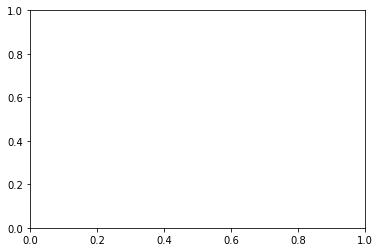

In [279]:
ax = nv.circos(G, group_by="venue", node_color_by="venue")
annotate.circos_group(G, group_by="venue")


In [259]:
G.nodes

NodeView(('-keskin', 'd-ekelschot', 'david-moxey', 'a-a-bukatov', 'a-k-pervitsky', 'andrei-m-sukhov', 'm-a-astrakhantseva', 's-boldyrev', 'a-al-yaari', 'j-p-wigneron', 'nj-rodrguez-fernndez', 'r-van-der-schalie', 'yann-h-kerr', 'a-astrid-pieterse', 'bmp-bart-jansen', 'a-bellagi', 'housam-binous', 'slim-kaddeche', 'a-ben-hamza', 'mohammed-khader', 'a-c-cem-say', 'abuzer-yakaryilmaz', 'a-chincarini', 'marina-boccardi', 'nicola-amoroso', 'rosalia-maglietta', 'stefania-bruno', 'a-corbo-esposito', 'f-calabr', 'a-csik', 'g-l-katona', 'h-zaka', 'm-medhat', 's-s-fouad', 'ss-shenouda', 'a-d-sarma', 'v-satya-srinivas', 'a-david-edwards', 'antonios-makropoulos', 'britta-hning', 'joseph-v-hajnal', 'nazakat-merchant', 'nora-tusor', 'paul-aljabar', 'robert-wright', 'tomoki-arichi', 'a-de-los-reyes-guzmn', 'fernando-trincado-alonso', 'iris-dimbwadyo-terrer', 'a-enis-cetin', 'deniz-cansen-yildirim', 'kivanc-kose', 'mohammad-tofighi', 'onur-yorulmaz', 'rengul-cetin-atalay', 'a-focke', 'b-threr', 'c-sto

In [222]:
authors = data['authors_clean']

#combanation of the authors that wrote the same  
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors) 
)

venues = data['venue_clean'].values
connections = np.array(author_connections, dtype=object)  + venues
df_authors_venue = pd.DataFrame(connections,columns=['connections'])
df_authors_venue['conference'] = df_authors_venue['connections'].apply(lambda x: x[-1] )
df_authors_venue['connections'] = df_authors_venue['connections'].apply(lambda x: x[:-1] )
df_connections = df_authors_venue.explode('connections','conference')
df_connections = df_connections[~df_connections['connections'].isnull()] 
df_connections.reset_index(inplace=True, drop=True)

flat_connections = [item for sublist in author_connections for item in sublist]
# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]

In [ ]:
# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(bag_of_authors).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.nodes[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )

ax = nv.circos(G_50, group_by="publications", node_color_by="publications")
annotate.circos_group(G_50, group_by="publications")


In [107]:
G_50.nodes

NodeView(('jin-li', 'chin-chen-chang', 'hai-jin', 'li-liu', 'chen-b', 'robert-w-heath', 'wei-wang', 'liqun-qi', 'wei-zhang', 'hui-li', 'karl-henrik-johansson', 'lajos-hanzo', 'huaguang-zhang', 'peng-zhang', 'xiaodong-li', 'li-li', 'azzedine-boukerche', 'jing-zhang', 'lei-wang', 'chau-yuen', 'lei-chen', 'yang-wang', 'mohamed-slim-alouini', 'gilbert-laporte', 'haiquan-zhao', 'abdulhameed-alelaiwi', 'licheng-jiao', 'c-l-philip-chen', 'shitong-wang', 'liangpei-zhang', 'dacheng-tao', 'jian-chen', 'yong-wang', 'athanasios-v-vasilakos', 'xin-wang', 'yi-zhang', 'yi-wang', 'jun-zhang', 'jie-wu', 'bo-li', 'jun-liu', 'robert-schober', 'xuelong-li', 'jie-chen', 'benny-sudakov', 'jun-li', 'ping-li', 'yang-liu', 'qi-wang', 'hui-zhang'))

In [ ]:
mapping = dict(
    {
        0: "Atlantic Coast",
        1: "Big East",
        2: "Big Ten",
        3: "Big Twelve",
        4: "Conference USA",
        5: "Independents",
        6: "Mid-American",
        7: "Mountain West",
        8: "Pacific Ten",
        9: "Southeastern",
        10: "Sun Belt",
        11: "Western Athletic",
    }
)
for node, data in G.nodes(data=True):
    G.nodes[node]["conference"] = mapping[data["value"]]

In [ ]:
pos = nodes.circos(G, group_by="conference", color_by="conference")
edges.circos(G, pos)
annotate.circos_group(G, group_by="conference")

despine()
aspect_equal()

In [ ]:
c = CircosPlot(
    G_50,
    dpi=600,
    node_grouping="publications",
    edge_width="Count",
    figsize=(20, 20),
    node_color="publications",
    node_labels=True,
)
c.draw()
plt.show()

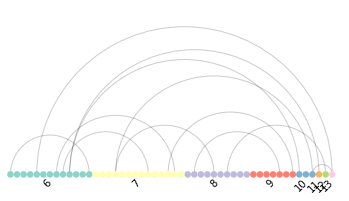

In [208]:
nv.arc(G_50, node_color_by="publications", group_by="publications")
annotate.arc_group(G_50, group_by="publications")


In [311]:
#model for semantic search (query similarity)
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
embeddings = model.encode(data['text_clean'].values)
print(embeddings)

[[ 0.02990917  0.02470112  0.00049384 ...  0.14277485 -0.04096054
  -0.00470103]
 [ 0.03741887 -0.08630216 -0.02435325 ... -0.02804396 -0.05163825
   0.01938225]
 [-0.02655261  0.0862579   0.04219936 ...  0.01161415 -0.01834993
   0.01689634]
 ...
 [-0.01083803 -0.0375764  -0.07169445 ... -0.08485531  0.00271295
   0.05114171]
 [-0.00584158  0.04895869  0.01795788 ... -0.02700021  0.06420294
   0.03360017]
 [ 0.05884707  0.0363559  -0.00641246 ... -0.0240707   0.00848056
  -0.00777332]]


In [312]:
embeddings.shape

(11130, 384)